In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from statsmodels.tsa.seasonal import seasonal_decompose
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
#Step 1: Load your dataset
data_count = pd.read_csv('C:/Users/a0095989/Desktop/important/Thesis/Model_Thesis/imputed_deu_data.csv', parse_dates=[0])
#data_count.head(20)

In [3]:
# Prepare the data
# Assuming 'data_count' is your dataframe and you want to predict 'AverageTemperature'
# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_count[['AverageTemperature', 'Year', 'Month', 'TemperatureAnomaly', 'YearlyAvgTemperature']])

# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 12  # Example sequence length
X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build the XLSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

c:\Users\a0095989\Desktop\important\Thesis\Model_Thesis\model\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step - loss: 0.0091 - val_loss: 0.0024
Epoch 2/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 50s 10ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 3/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 4/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 5/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 6/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 7/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 8/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 9/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 10/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 11/20
5247/5247 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 12/20
5247/5

In [5]:
# Make predictions
predictions = model.predict(X_test)

# Print the predictions
print(predictions)

1640/1640 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
[[0.37011406]
 [0.3309409 ]
 [0.32384247]
 ...
 [0.936126  ]
 [0.8400472 ]
 [0.7898649 ]]


1640/1640 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


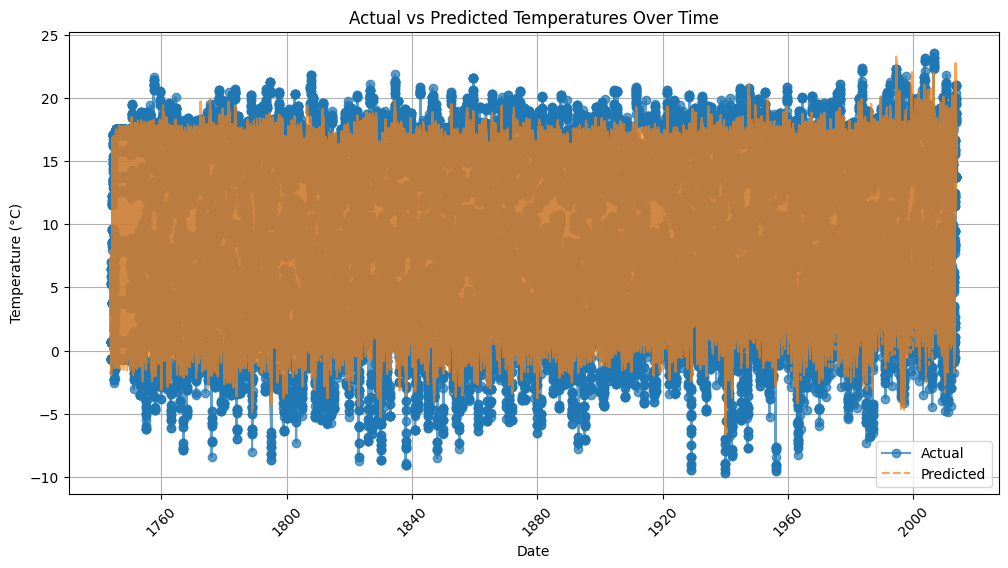

In [23]:
# Inverse transform the scaled y_test and predictions
y_test_scaled = y_test.reshape(-1, 1)  # Ensure y_test is 2D
y_test_unscaled = scaler.inverse_transform(
    np.hstack((y_test_scaled, np.zeros((y_test_scaled.shape[0], data_scaled.shape[1] - 1))))
)

y_pred_scaled = model.predict(X_test)  # Predicted y values
y_pred_unscaled = scaler.inverse_transform(
    np.hstack((y_pred_scaled, np.zeros((y_pred_scaled.shape[0], data_scaled.shape[1] - 1))))
)

# Extract only the first column for actual and predicted values
y_test_unscaled = y_test_unscaled[:, 0]
y_pred_unscaled = y_pred_unscaled[:, 0]

# Extract corresponding dates for the test set
time_steps = data_count['dt'].values[-len(y_test_unscaled):]  # Get the dates for the test set

# Plot with meaningful x-axis (dates)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(time_steps, y_test_unscaled, label='Actual', linestyle='-', marker='o', alpha=0.7)
plt.plot(time_steps, y_pred_unscaled, label='Predicted', linestyle='--', alpha=0.7)
plt.xlabel('Date')  # Set x-axis to display real dates
plt.ylabel('Temperature (°C)')  # Add units for temperature
plt.title('Actual vs Predicted Temperatures Over Time')  # Add title
plt.legend()
plt.grid(True)  # Add grid for readability
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


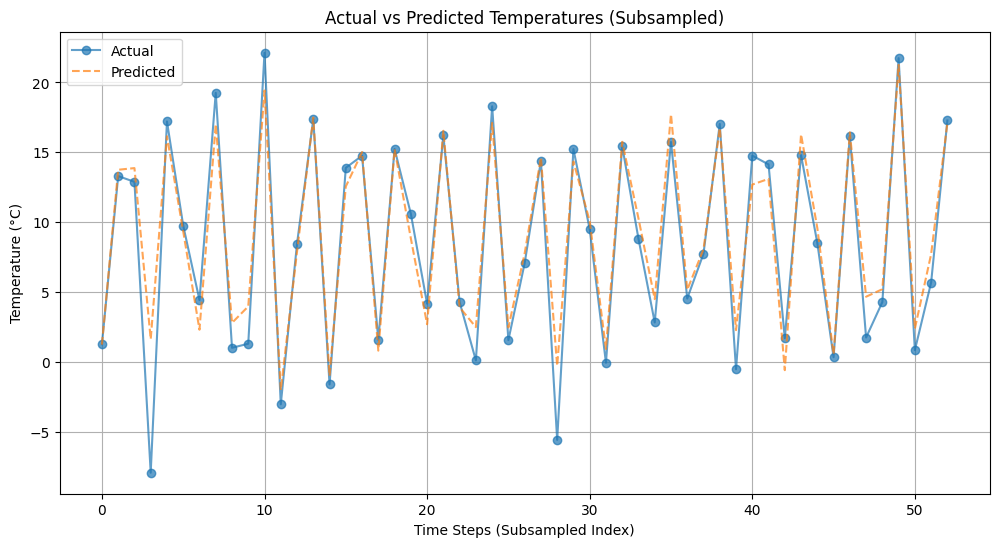

In [ ]:
# Subsample the data for visualization
step = 1000  # Plot every 100th data point

# Subsample the predictions and actual values
y_test_subsampled = y_test_unscaled[::step]
y_pred_subsampled = y_pred_unscaled[::step]

plt.figure(figsize=(12, 6))
plt.plot(y_test_subsampled, label='Actual', linestyle='-', marker='o', alpha=0.7)
plt.plot(y_pred_subsampled, label='Predicted', linestyle='--', alpha=0.7)
plt.xlabel('Time Steps (Subsampled Index)')  # Maintain original subsampled indices
plt.ylabel('Temperature (°C)')  # Add units for temperature
plt.title('Actual vs Predicted Temperatures (Subsampled)')
plt.legend()
plt.grid(True)  # Add grid for readability
plt.show()


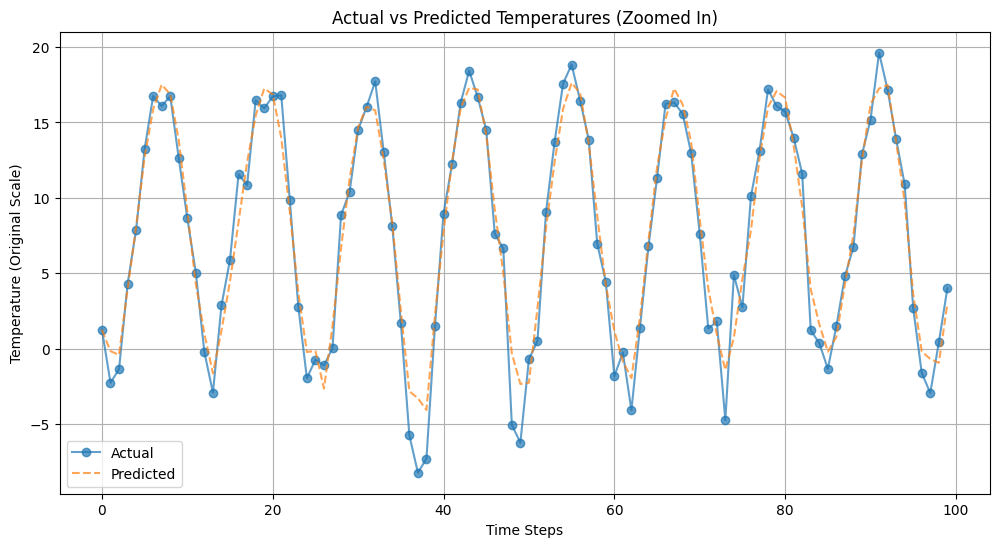

: 

In [40]:
start, end = 0, 100  # Zoom in on the first 500 points
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled[start:end], label='Actual', linestyle='-', marker='o', alpha=0.7)
plt.plot(y_pred_unscaled[start:end], label='Predicted', linestyle='--', alpha=0.7)
plt.xlabel('Time Steps')
plt.ylabel('Temperature (Original Scale)')
plt.title('Actual vs Predicted Temperatures (Zoomed In)')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
import numpy as np

# Calculate Mean Absolute Percentage Error (MAPE)
xlstm_mape = np.mean(np.abs((y_test_unscaled - y_pred_unscaled) / y_test_unscaled)) * 100
print(f"Mean Absolute Percentage Error (MAPE) for XLSTM: {xlstm_mape}%")


Mean Absolute Percentage Error (MAPE) for XLSTM: 90.15943723256623%


In [15]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
print(f"Mean Absolute Error (MAE): {mae}")


Mean Absolute Error (MAE): 1.1745158090240968


In [16]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 1.5329785066620207


In [17]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test_unscaled, y_pred_unscaled)
print(f"R² Score: {r2}")


R² Score: 0.9486794809950706


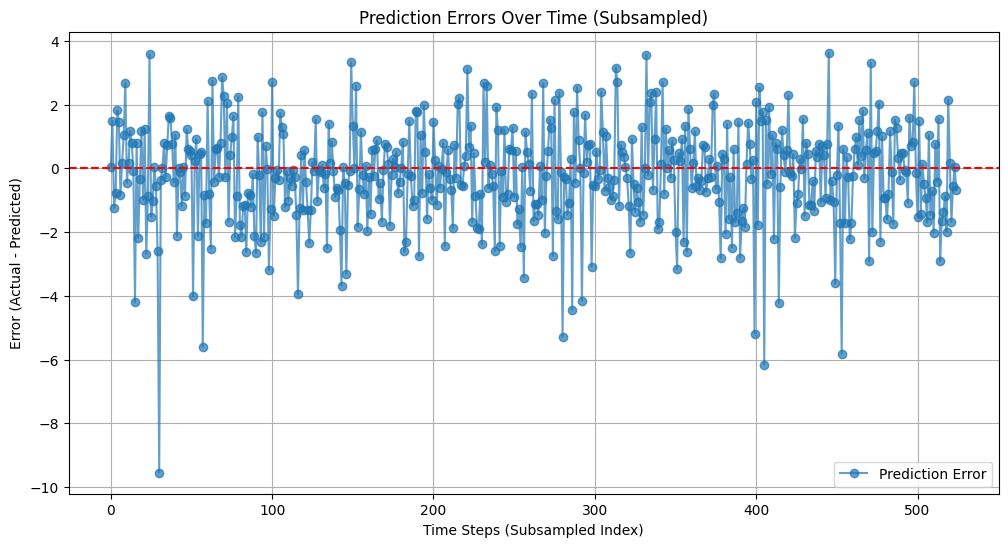

In [32]:
errors = y_test_unscaled - y_pred_unscaled
plt.figure(figsize=(12, 6))
plt.plot(errors[::step], label='Prediction Error', linestyle='-', marker='o', alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Time Steps (Subsampled Index)')
plt.ylabel('Error (Actual - Predicted)')
plt.title('Prediction Errors Over Time (Subsampled)')
plt.legend()
plt.grid(True)
plt.show()


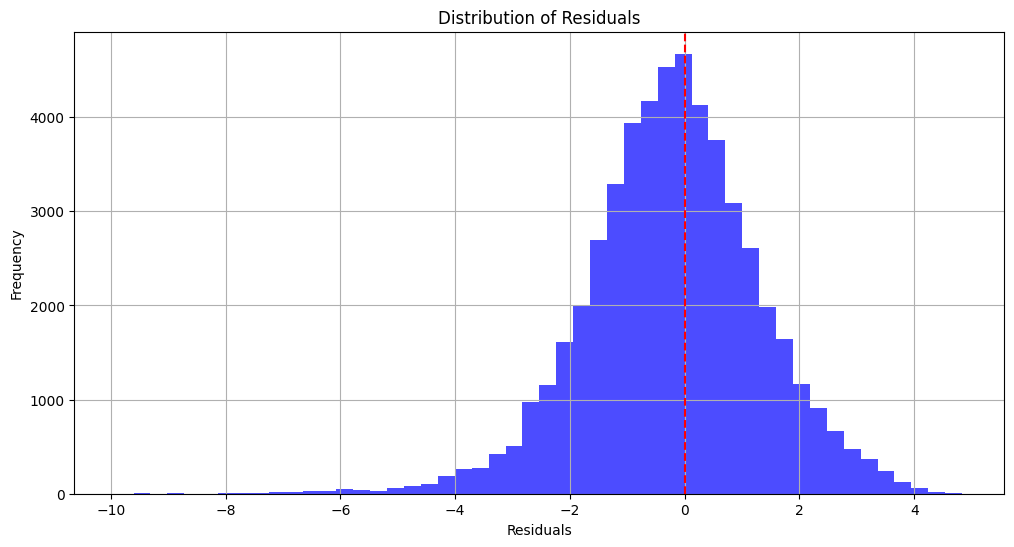

In [33]:
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50, alpha=0.7, color='blue')
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


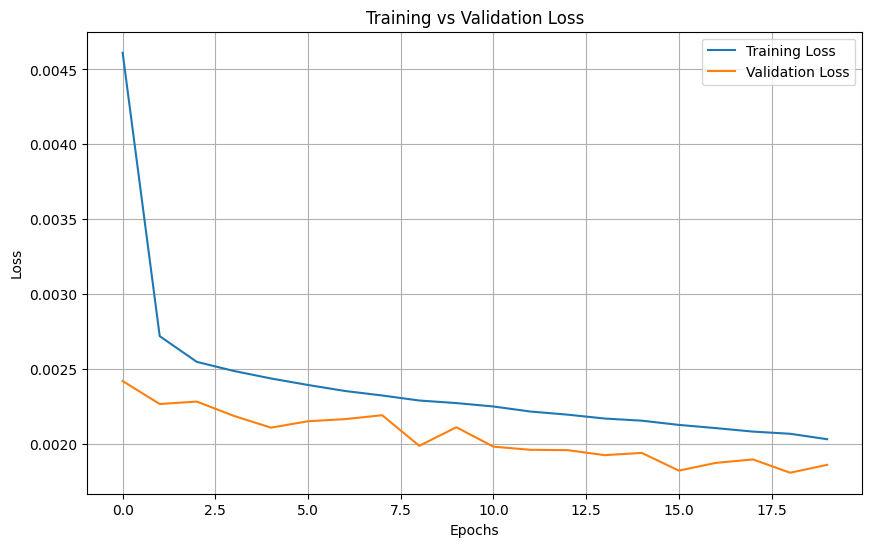

In [37]:
import matplotlib.pyplot as plt

# Extract loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
